In [1]:
#default_exp evaluation 

In [2]:
%cd ..
%matplotlib inline

/home/kuba/Projects/deeplearning_image_pixelwise


In [3]:
#export
import sys
from tensorflow.keras import losses, metrics, layers, models
from deeplearning_image_pixelwise import data, config, segmentation_model_training 

import tensorflow as tf
from mlutil import guild
import skimage
import numpy as np

import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore')

gpu_devices = tf.config.experimental.list_physical_devices('GPU')
for device in gpu_devices:
    tf.config.experimental.set_memory_growth(device, True)
    

if config.float_dtype == 'float16':
    tf.keras.backend.set_floatx('float16')
    tf.keras.backend.set_epsilon(1e-4)
    policy = tf.keras.mixed_precision.experimental.Policy('mixed_float16')
    tf.keras.mixed_precision.experimental.set_policy(policy)

/etc/conda/envs/testml/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.feature_extraction.stop_words module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_extraction.text. Anything that cannot be imported from sklearn.feature_extraction.text is now part of the private API.
  warnings.warn(message, FutureWarning)


Set this variable to False if you have models trained with guild.

To get pretrained models and their runs execute

`bash scripts/get_guild_runs.sh`

In [4]:
USE_STORED_RUNS = True 
RUNS_PATH = 'guild'

In [5]:
operation_name = 'deeplearing_image_pixelwise:segmentation_model_training'
if not USE_STORED_RUNS:
    RUNS_PATH = guild.get_current_guild_env_path()
runs_df = guild.get_training_runs(operation_name, RUNS_PATH)

In [6]:
runs_df

,run,operation,started,status,label
0,d29e9465,deeplearing_image_pixelwise:segmentation_model...,2020-06-05 05:29:03,completed,BASE_N_FILTERS=4 BATCH_SIZE=24
1,52e72199,deeplearing_image_pixelwise:segmentation_model...,2020-06-05 01:43:19,completed,BASE_N_FILTERS=4 BATCH_SIZE=16
3,a3f5b3a8,deeplearing_image_pixelwise:segmentation_model...,2020-06-04 16:58:50,terminated,ACTIVATION=elu BATCH_SIZE=16
4,335a8418,deeplearing_image_pixelwise:segmentation_model...,2020-06-04 12:47:32,completed,BATCH_SIZE=16
6,bede3090,deeplearing_image_pixelwise:segmentation_model...,2020-06-04 12:45:52,error,BATCH_SIZE=16
8,9dd6077d,deeplearing_image_pixelwise:segmentation_model...,2020-06-04 12:45:31,terminated,ACTIVATION=elu BATCH_SIZE=16
9,ecd5c2d4,deeplearing_image_pixelwise:segmentation_model...,2020-06-04 12:45:27,error,BATCH_SIZE=16
12,f40c256e,deeplearing_image_pixelwise:segmentation_model...,2020-06-04 04:45:16,completed,BATCH_SIZE=24
13,82d9311b,deeplearing_image_pixelwise:segmentation_model...,2020-06-04 00:36:43,completed,BATCH_SIZE=16


In [7]:
run_id = runs_df['run'].iloc[-2]
latest_weights_path = guild.get_weight_files(run_id, RUNS_PATH)[-1]

In [8]:
!ls $RUNS_PATH/runs

0e09cce0ba124edf9476a3f14ed1b172  918ca05977914eac9de10952e0218465
258468ec86454c35a68df0e14908ee21  9dd6077d083e445e8dc7093670acca5f
2efea5a2287d4fdd94e258364a1c27d9  a3f5b3a8983444cabf5bb6594c27b827
335a84183b944c0d992d4e27d2e3cb12  abd04c5179ec440ca23d453b51e2614f
38718dc5b3be4cea97ff2f2734047a4c  bede3090e0e849b6a1730eee501ae611
4a5b748d1f184084ac68d638a19b9b18  c4e190d2785c452091b16861a722de7b
4aa2773d1977474db86ec3a6be568395  caf6468840d040c88472da4b0f4762d3
52e72199a8e54275938c4deae93deac7  d29e9465ce5f46369b2259b14396f303
5d13ea8d5ca8443fb41fea7d59ae1f15  d8dfefc90d964291b499622ff564cd35
815d2dda53d64e16a1752d665e9d94fd  dbca4f75b7694d6e82d475d2fb9dce43
82d9311be92a47889f9444f6015b9f92  ec4f8d791d444c08a7e2df5b5bd6779a
83f663efb7c1469b81574a9e956d6a8e  ecd5c2d47bbd46aa8ade9a9a25b8ae42
8d92432b3b07427ea93f9c8624768162  f40c256eaeca441d95f7934b06659484


In [9]:
#export

segmentation_model = segmentation_model_training.build_segmentation_model(
    input_shape=(config.IMG_HEIGHT, config.IMG_WIDTH, 3),
    n_classes=config.N_CLASSES,
)

In [10]:
segmentation_model.load_weights(latest_weights_path)

In [11]:
segmentation_model

In [12]:
val_dataset = data.load_dataset(config.VAL_DIR, config.VAL_MASK_DIR)

# Show results

We show image, true mask and predicted mask

(224, 224, 3)


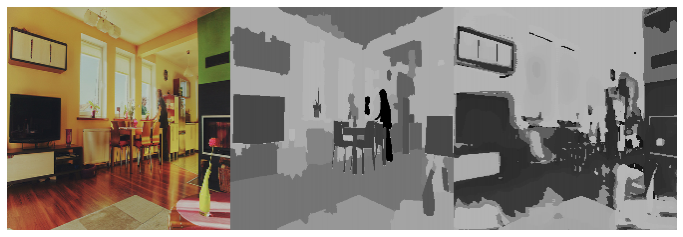

(224, 224, 3)


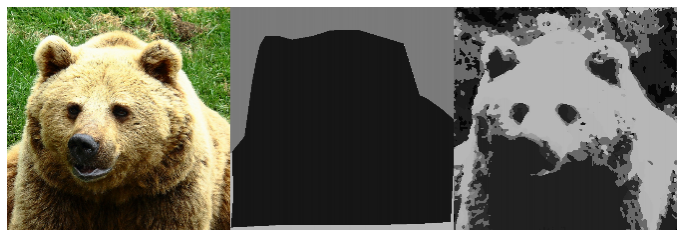

(224, 224, 3)


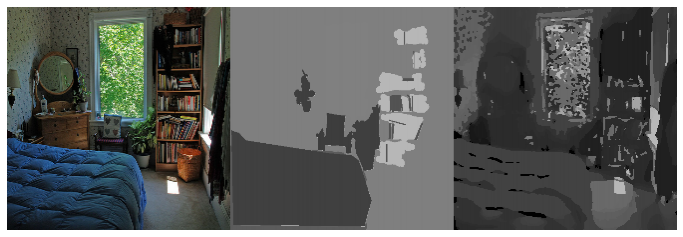

(224, 224, 3)


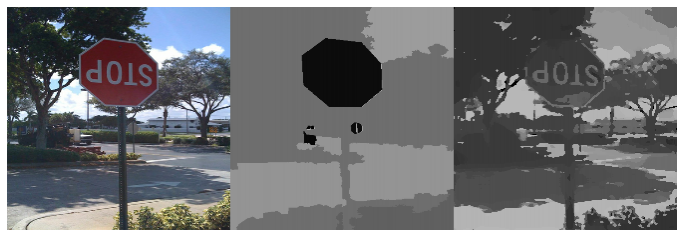

(224, 224, 3)


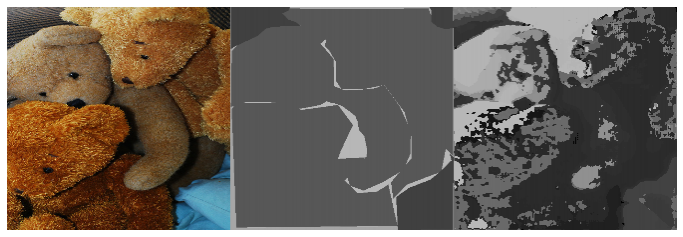

(224, 224, 3)


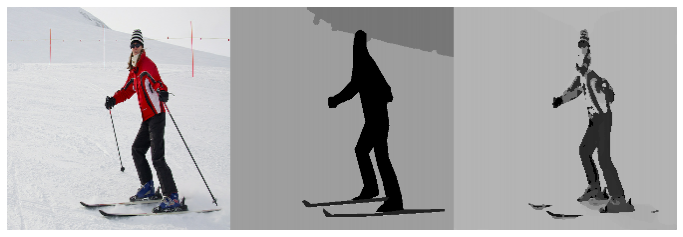

(224, 224, 3)


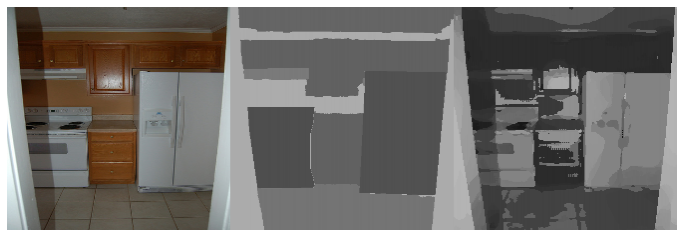

(224, 224, 3)


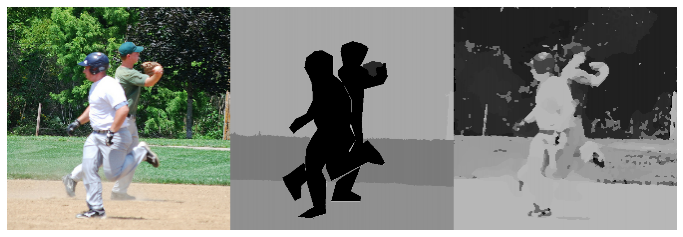

(224, 224, 3)


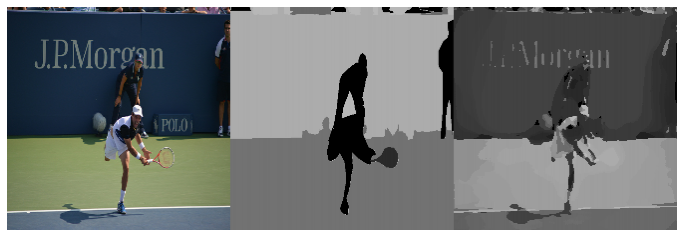

(224, 224, 3)


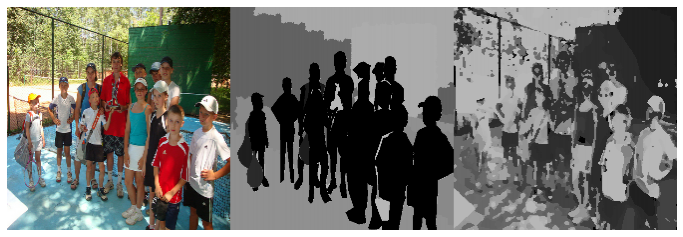

In [13]:
for batch in val_dataset.take(10):
    img, mask = batch
    img = img.numpy()
    mask = mask.numpy()
    predicted_mask = segmentation_model.predict(img.reshape(-1, 224, 224, 3)).argmax(axis=-1)
    img = (img * data.image_std) + data.image_mean
    predicted_mask_gray = skimage.color.gray2rgb(predicted_mask[0] / 255.0)
    mask_gray = skimage.color.gray2rgb(mask.astype('float')[:,:,0] / 255.0)
    print(mask_gray.shape)
    plt.figure(figsize=(12, 6))
    plt.imshow(np.hstack([img, mask_gray, predicted_mask_gray]))
    plt.axis('off')
    plt.show()